# Removal of cell-cycle and sex covariates (with integration)
 

We show consider a dataset of Drosophila myoblasts [[1]](https://doi.org/10.7554/eLife.61276). We show that that conditioning on the gene expression from cell sex and cell cycle marker genes `SiFT` is able to deconfound cell sex and cell cycle effects while preserving signal from the other genes.

[[1] Everetts, N. J., Worley, M. I., Yasutomi, R., Yosef, N., & Hariharan, I. K. (2021). Single-cell transcriptomics of the Drosophila wing disc reveals instructive epithelium-to-myoblast interactions. Elife, 10, e61276.](https://doi.org/10.7554/eLife.61276)

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scvi
import anndata
import pandas as pd
import scanpy as sc
import numpy as np

import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import time
import scib
from scipy.sparse import issparse

import sift

Global seed set to 0
/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR

## Set Parameteres

In [4]:
DATA_DIR = DATA_DIR / "nuisance_drosophila"
FIG_DIR = FIG_DIR / "nuisance_drosophila"

In [5]:
import seaborn as sns
fontsize = 20
size = 4
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (size, size)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = fontsize
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = fontsize-4
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = fontsize-4
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = fontsize+4
plt.rcParams['legend.handlelength'] = 1.4 
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

sns.set(rc={"figure.dpi":300, "savefig.dpi":300})
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid", {"xtick.direction": "out", "xtick.major.size": 3.0, "xtick.minor.size": 3.0,
                            "ytick.color": ".15", "ytick.direction": "out", "ytick.major.size": 3.0, 
                            "ytick.minor.size": 3.0, "font": ["DejaVu Sans"], "font.scale": 1, 
                            "legend.frameon":"True"})

In [6]:
method_colors = ["#5C88DAFF", "#84BD00FF", "#FFCD00FF"] 
coupled_method_colors = ["#5C88DAFF", "#5C88DA99", "#84BD00FF",  "#84BD0099", "#FFCD00FF", "#7C878EFF"]

## Helper functions

In [7]:
def set_adata_colors(adata):
    # set sex
    adata.uns["sex_colors"] = list(sns.color_palette("colorblind", 2).as_hex()[::-1])
    
    # set phase
    adata.obs["phase"] = adata.obs["phase"].astype("category")
    adata.obs["phase"] = adata.obs["phase"].cat.reorder_categories(['G1',  'S', 'G2M'])
    
    colors_ = list(sns.color_palette("Paired", 6).as_hex())
    adata.uns["phase_colors"] = [colors_[1], colors_[3], colors_[5]]
    
    # set batch
    adata.obs["batch_str"] = adata.obs["batch"].copy()
    adata.obs["batch_str"] = adata.obs["batch_str"].cat.rename_categories({
        '96hr_1': "96hr (1)", 
        '96hr_2': "96hr (2)", 
        '120hr_1': "120hr (1)", 
        '120hr_2': "120hr (2)", 
    })
    adata.uns["batch_str_colors"] = ["#92aeb3", "#c9c89d", "#999999", "#392b2b"]

    # set phase-sex
    adata.obs["phase_sex"] = adata.obs["phase"].astype(str) + "_" + adata.obs["sex"].astype(str)
    adata.obs["phase_sex"] = adata.obs["phase_sex"].astype("category")
    adata.obs["phase_sex"] = adata.obs["phase_sex"].cat.reorder_categories([
        'G1_female',  'G1_male', 
        'S_female',  'S_male', 
        'G2M_female',  'G2M_male', 
    ])
    adata.obs["phase_sex"] = adata.obs["phase_sex"].cat.rename_categories({
        'G1_female' : "G1 (f)",  
        'G1_male': "G1 (m)",
        'S_female': "S (f)",  
        'S_male': "S (m)",
        'G2M_female': "G2M (f)",
        'G2M_male': "G2M (m)", 
    })
    adata.uns["phase_sex_colors"] = list(sns.color_palette("Paired", 6).as_hex())
    

    
    return adata

## Setting parameters

In [8]:
# list of sex genes and cell cycle genes we will be conditioning on
sex_genes = ["lncRNA:roX1", "lncRNA:roX2", "Sxl", "msl-2"]

cell_cycle_genes = ['PCNA', 'dnk', 'RnrS', 'RnrL', 'Claspin', 'Mcm5', 'Caf1-180',
       'RPA2', 'HipHop', 'stg', 'Mcm6', 'dup', 'WRNexo', 'Mcm7', 'dpa',
       'CG10336', 'Mcm3', 'Mcm2', 'RpA-70', 'Chrac-14', 'CG13690', 'RPA3',
       'asf1', 'DNApol-alpha73', 'CycE', 'DNApol-alpha50',
       'Kmn1', 'Lam', 'Nph', 'msd5', 'msd1', 'ctp', 'Set', 'scra',
       'Chrac-16', 'ncd', 'Ote', 'pzg', 'HDAC1', 'nesd', 'tum', 'CG8173',
       'aurB', 'feo', 'pav', 'CG6767', 'sip2', 'Det', 'Cks30A', 'CycB',
       'B52']

# list of genes we're interested in
genes_of_interest = [
    "Argk",
    "Nrt",
    "Ten-a",
    "Ten-m",
    "wb",
    "Act57B",
    "drl",
    "mid",
    "nemy",
    "lms",
    "CG11835",
    "Gyg",
    "ara",
    "tok",
    "kirre",
    "NK7.1",
    "fj",
    "beat-IIIc",
    "CG33993",
    "dpr16",
    "CG15529",
    "CG9593",
    "beat-IIb",
    "robo2",
    "Ama",
    "fz2",
    "elB",
    "noc",
    "nkd",
    "fng",
    "vg",
]

nuisance_genes = sex_genes + cell_cycle_genes

library_size = 5000

## Pre-process data

In [10]:
# setting up anndata
adata = sc.read(DATA_DIR / 'myoblasts.h5ad')

In [11]:
adata.layers['counts'] = adata.X.copy() # move count data into a layer
sc.pp.normalize_total(adata)
sc.pp.log1p(adata) # log the data for better umap visualization later
adata.raw = adata

**Classify the `sex`**

based on the classification performed by Everetts et. al. [[1]]((https://doi.org/10.7554/eLife.61276)) (see [cell_sex_and_cell_cycle_correction.R](https://github.com/HariharanLab/Everetts_Worley_Yasutomi/blob/e1d1f10fefdab11688ad4ca0b8c2684ed47faa0c/scVI/cell_sex_and_cell_cycle_correction.R))

_sc.pp.neighborsWe expect the data for sex genes to be bimodal, and use the minimum between peaks as a cutoff for determining male and female cells. This usually corresponds to the second extrema in the density (from left to right). However, noise and drop-outs in the data may make this difficult to calculate, so a manual cutoff may be needed instead._
  

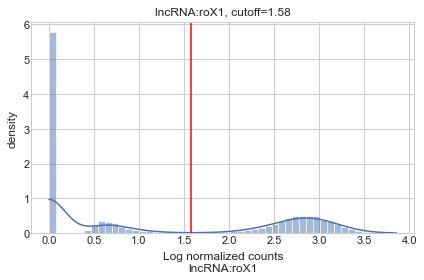

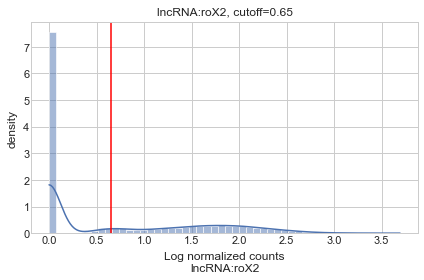

Number of predicted male cells: 8510, percentage from data: 0.43
Number of predicted female cells: 11375, percentage from data: 0.57


In [12]:
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import vectors

stats = importr("stats")

sex_gene_cutoff = {}
data_density = {}
sex_threshold_cells = {}
sex_genes = ["lncRNA:roX1", "lncRNA:roX2"]

# get density estimate

for i, gene in enumerate(sex_genes):
    column = vectors.FloatVector(adata[:, gene].X)
    data_density[gene]  = stats.density(column, adjust = 2)
    x = np.asarray(data_density[gene][0])
    y = np.asarray(data_density[gene][1])
    # find the second extrema in the density, and use this as a cutoff for cells
    sex_gene_cutoff[gene] = x[np.where(np.diff(np.diff(y) > 0))][1]
    adata.obs[f"{gene}_cutoff"] = adata[:, gene].X >= sex_gene_cutoff[gene]
    
    ax = sns.histplot(adata[:, gene].X, stat="density", bins=50, kde=True)
    ax.legend().remove()
    ax.set_xlabel(f"Log normalized counts\n{gene}")
    ax.set_ylabel(f"density")
    plt.axvline(x=sex_gene_cutoff[gene],color='red')
    plt.title(f"{gene}, cutoff={sex_gene_cutoff[gene]:.2f}")
    
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"sex_cutoff_{gene}.png", bbox_inches="tight", dpi=DPI)
    plt.show()
    
adata.obs["sex"] = "female"
adata.obs.loc[adata.obs["lncRNA:roX1_cutoff"] | adata.obs["lncRNA:roX2_cutoff"], "sex"]  = "male"


num_male = (adata.obs["sex"] == "male").sum()
num_female = (adata.obs["sex"] == "female").sum()
print(f"Number of predicted male cells: {num_male}, percentage from data: {num_male/(num_male+num_female):.2f}")
print(f"Number of predicted female cells: {num_female}, percentage from data: {num_female/(num_male+num_female):.2f}")

Classify cell cycle based on cell cycle genes from Kirchner [Drosophila_melanogaster.csv](https://github.com/hbc/tinyatlas/blob/master/cell_cycle/Drosophila_melanogaster.csv) as used in Zhu et al. [[2]](https://doi.org/10.1038/s41467-022-28915-3)

[[2] Kiat, Y., Vortman, Y., & Sapir, N. (2019). Feather moult and bird appearance are correlated with global warming over the last 200 years. Nature Communications, 10(1), 1-7.](https://doi.org/10.1038/s41467-022-28915-3)


In [13]:
g2m_genes = [
    'Mps1', 'aurA', 'CycB', 'fzy', 'twe', 'pbl', 'RanGAP', 'stg',
    'sub', 'Su(var)205', 'Cdk1', 'Klp61F', 'pie', 'pav', 'glu', 'msps',
    'pigs', 'Nek2', 'HP1b', 'Phf7', 'Bub1', 'mars', 'Mapmodulin',
    'LBR', 'CTCF', 'Cks85A', 'HP1e', 'HP1c', 'Cap-D2', 'cmet', 'cana',
    'scra', 'BubR1', 'Det', 'vih', 'Dsp1', 'Top2'
]
s_genes = [
    'Blm', 'spn-A', 'PCNA', 'CycE', 'RnrS', 'DNApol-alpha50',
    'l(2)dtl', 'Mcm2', 'spel1', 'tos', 'dpa', 'Mcm5', 'Ts', 'Mcm6',
    'Fen1', 'Cdc45', 'Usp1', 'CG15141', 'CG10336', 'PCNA2', 'RPA2',
    'Caf1-105', 'CG11788', 'Cdc6', 'Slbp', 'Claspin',
    'DNApol-alpha180', 'RfC4', 'Psf2'
]

In [14]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [15]:
adata = set_adata_colors(adata)

In [16]:
adata_nothing = adata.copy()

In [17]:
sc.pp.scale(adata_nothing)
sc.tl.pca(adata_nothing)
sc.pp.neighbors(adata_nothing)
sc.tl.umap(adata_nothing)

Text(0.5, 1.0, 'cc phase & sex')

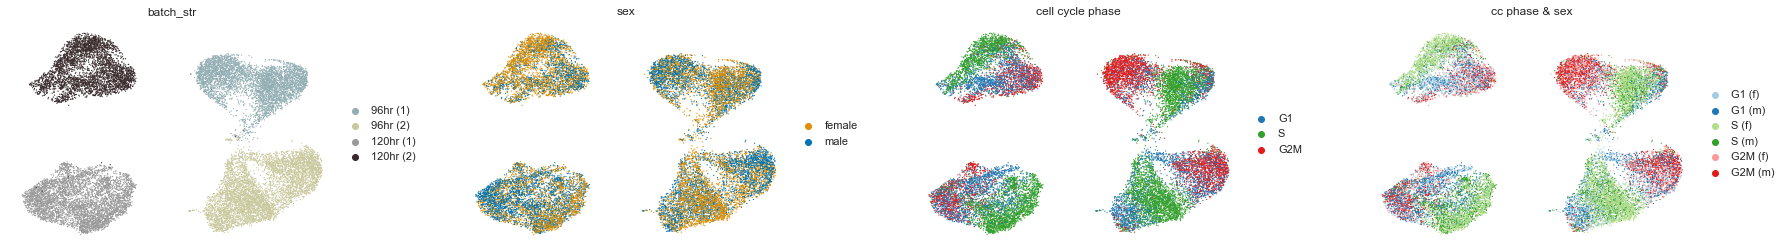

In [18]:
fig = sc.pl.umap(
        adata_nothing,
        color=["batch_str", "sex",  "phase", "phase_sex"],
        frameon=False,
        wspace=0.25,
        return_fig=True,
    )
fig.axes[2].set_title("cell cycle phase")
fig.axes[3].set_title("cc phase & sex")

In [ ]:
adata_nothing.write(DATA_DIR / "myoblasts_nothing.h5ad")

In [ ]:
adata.write(DATA_DIR / "myoblasts_annotated.h5ad")

## Read pre-processed

In [ ]:
adata = sc.read(DATA_DIR / "myoblasts_annotated.h5ad")

In [19]:
methods = ["sift_bbknn", "sift_harmony", "regress_out_bbknn", "regress_out_harmony", "scvi_cond_batch", "nothing"]
fnames = {method: f"myoblasts_{method}.h5ad" for method in methods}

In [20]:
adatas_ = {}

# `SiFT` + `batch_correction` methods

In [21]:
metric = "knn"
method = methods[0]
n_neighbors = 3

## `bbknn`

In [22]:
# setting up anndata for sift

adatas_[method] = adata.copy()

# then copy the expression of the nuisance gene into adata.obsm
adatas_[method].obsm["nuisance_genes"] = adatas_[method][:, nuisance_genes].X
adatas_[method].uns["nuisance_genes"] = nuisance_genes


# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adatas_[method].var_names if g not in nuisance_genes]
adatas_[method] = adatas_[method][:, gene_subset].copy()


In [23]:
start = time.perf_counter()

print(f"running {method}")    
kernel_key_ =  "nuisance_genes"     

sft = sift.SiFT(
    adata=adatas_[method],
    kernel_key=kernel_key_,
    n_neighbors=n_neighbors,
    metric=metric,
    copy=False,
)
sft.filter(
    embedding_key="X",
)
compute_time = time.perf_counter() - start
print(f"{method} finished in {compute_time} sec")


running sift_bbknn
INFO     sift: initialized a SiFTer with knn kernel.                                                               
INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                
sift_bbknn finished in 4.503553231013939 sec


In [24]:
adatas_[method].layers["X_sift"]  = adatas_[method].X.copy()
adatas_[method].X -= adatas_[method].X.min()
sc.tl.pca(adatas_[method])
sc.external.pp.bbknn(adatas_[method], batch_key="batch")
sc.tl.umap(adatas_[method])

In [ ]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

## `Harmony`

In [25]:
metric = "knn"
method = methods[1]
n_neighbors = 5

In [26]:
# setting up anndata for sift

adatas_[method] = adata.copy()

# then copy the expression of the nuisance gene into adata.obsm
adatas_[method].obsm["nuisance_genes"] = adatas_[method][:, nuisance_genes].X
adatas_[method].uns["nuisance_genes"] = nuisance_genes


# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adatas_[method].var_names if g not in nuisance_genes]
adatas_[method] = adatas_[method][:, gene_subset].copy()


In [27]:
start = time.perf_counter()

print(f"running {method}")    
kernel_key_ =  "nuisance_genes"     

sft = sift.SiFT(
    adata=adatas_[method],
    kernel_key=kernel_key_,
    n_neighbors=n_neighbors,
    metric=metric,
    copy=False,
)

sft.filter(
    embedding_key="X",
)
compute_time = time.perf_counter() - start
print(f"{method} finished in {compute_time} sec")


running sift_harmony
INFO     sift: initialized a SiFTer with knn kernel.                                                               
INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                
sift_harmony finished in 2.567013541003689 sec


In [28]:
adatas_[method]

AnnData object with n_obs × n_vars = 19885 × 3332
    obs: 'batch', 'lncRNA:roX1_cutoff', 'lncRNA:roX2_cutoff', 'sex', 'S_score', 'G2M_score', 'phase', 'batch_str', 'phase_sex'
    uns: 'cell_cycle_genes', 'sex_genes', 'log1p', 'sex_colors', 'phase_colors', 'batch_str_colors', 'phase_sex_colors', 'nuisance_genes', 'kernel'
    obsm: 'nuisance_genes'
    layers: 'counts'
    obsp: 'sift_connectivities'

In [29]:
adatas_[method].layers["X_sift"]  = adatas_[method].X.copy()
adatas_[method].X -= adatas_[method].X.min()
sc.tl.pca(adatas_[method])
sc.external.pp.harmony_integrate(adatas_[method], key="batch")
sc.pp.neighbors(adatas_[method], use_rep="X_pca_harmony")
sc.tl.umap(adatas_[method])


2022-11-02 17:02:37,146 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2022-11-02 17:02:43,714 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2022-11-02 17:02:50,239 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


In [ ]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

# `Scanpy` + `batch_correction` methods

In [30]:
method_bbknn = methods[2]
method_harmony = methods[3]

## Scanpy

We run scanpy's `regress_out()` as a baseline.

In [31]:
# setting up anndata for scvi with conditioning on nuisance genes
adata_regress_out = adata.copy()

# then copy the expression of each nuisance gene into adata.obs where the key
# is the gene name
for g in nuisance_genes:
    exp = adata_regress_out[:,g].X
    adata_regress_out.obs[g] = exp.copy()

# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adata.var_names if g not in nuisance_genes]
adata_regress_out = adata_regress_out[:,gene_subset].copy()

In [32]:
# takes ~ 15 min to run 
adatas_[method_bbknn] = sc.pp.regress_out(adata_regress_out, nuisance_genes, copy=True)
adatas_[method_harmony] = adatas_[method_bbknn].copy()

## `bbknn`

In [33]:
sc.pp.scale(adatas_[method_bbknn])
sc.tl.pca(adatas_[method_bbknn])
sc.external.pp.bbknn(adatas_[method_bbknn])
sc.tl.umap(adatas_[method_bbknn])

In [ ]:
adatas_[method_bbknn].write(DATA_DIR / f"myoblasts_{method_bbknn}.h5ad")

## Harmony

In [34]:
sc.pp.scale(adatas_[method_harmony])
sc.tl.pca(adatas_[method_harmony])
sc.external.pp.harmony_integrate(adatas_[method_harmony], key="batch")
sc.pp.neighbors(adatas_[method_harmony], use_rep="X_pca_harmony")
sc.tl.umap(adatas_[method_harmony])

2022-11-02 19:22:31,257 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2022-11-02 19:22:37,928 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2022-11-02 19:22:44,653 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


In [ ]:
adatas_[method_harmony].write(DATA_DIR / f"myoblasts_{method_harmony}.h5ad")

# scVI with extra covariates

In this second part of the tutorial, we train scVI on extra categorical covariates. 

In our case, we would like to condition our latent represenation on cell cycle and cell sex gene expression in order to learn a latent representation that is independant of cell sex and cell cycle. 

In [35]:
method = methods[4]

In [36]:
# setting up anndata for scvi with conditioning on nuisance genes
adatas_[method] = adata.copy()

# then copy the expression of each nuisance gene into adata.obs where the key
# is the gene name
for g in nuisance_genes:
    exp = adatas_[method][:,g].X
    adatas_[method].obs[g] = exp.copy()

# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adatas_[method].var_names if g not in nuisance_genes]
adatas_[method] = adatas_[method][:,gene_subset].copy()

# run setup_anndata with our list of nuisance genes as our continuous covariates
scvi.model.SCVI.setup_anndata(adatas_[method],
                              batch_key = 'batch',
                              continuous_covariate_keys=nuisance_genes, 
                              layer='counts')

## Training

In [37]:
cond_model = scvi.model.SCVI(adatas_[method])
cond_model.train()

Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 400/400: 100%|██| 400/400 [10:53<00:00,  1.71s/it, loss=2.54e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██| 400/400 [10:53<00:00,  1.63s/it, loss=2.54e+03, v_num=1]


## Extract

Here we extract the latent space of our `scVI` model trained with expression from our nuisance genes as a continuous covariate.

In [38]:
adatas_[method].obsm["X_emb"] = cond_model.get_latent_representation()
adatas_[method].layers["X"] =  adatas_[method].X.copy()
adatas_[method].layers["X_scvi_norm"] = cond_model.get_normalized_expression(adatas_[method], library_size = library_size)

In [39]:
# log1p scvi normalized expression
adatas_[method].layers["scvi_norm_log"] = np.log1p(adatas_[method].layers["X_scvi_norm"])
# set layer to scvi_norm_log prior to scaling and clustering
adatas_[method].X = adatas_[method].layers["scvi_norm_log"]

In [40]:
# scale expression
sc.pp.scale(adatas_[method])

In [41]:
sc.pp.neighbors(adatas_[method], use_rep = "X_emb")
sc.tl.umap(adatas_[method])

In [ ]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

# Nothing

In [42]:
method = methods[5]

In [43]:
adatas_[method] = adata.copy()
sc.pp.scale(adatas_[method])
sc.tl.pca(adatas_[method])
sc.pp.neighbors(adatas_[method])
sc.tl.umap(adatas_[method])

In [ ]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

# Analysis

## Import data

In [ ]:
methods = ["sift_bbknn", "sift_harmony", "regress_out_bbknn", "regress_out_harmony", "scvi_cond_batch", "nothing"]
metrics = ["knn"]

In [ ]:
adatas_ = {}

In [ ]:
for method in methods:
    datas_[method] = sc.read(DATA_DIR / f"myoblasts_{method}.h5ad")

## Plot data

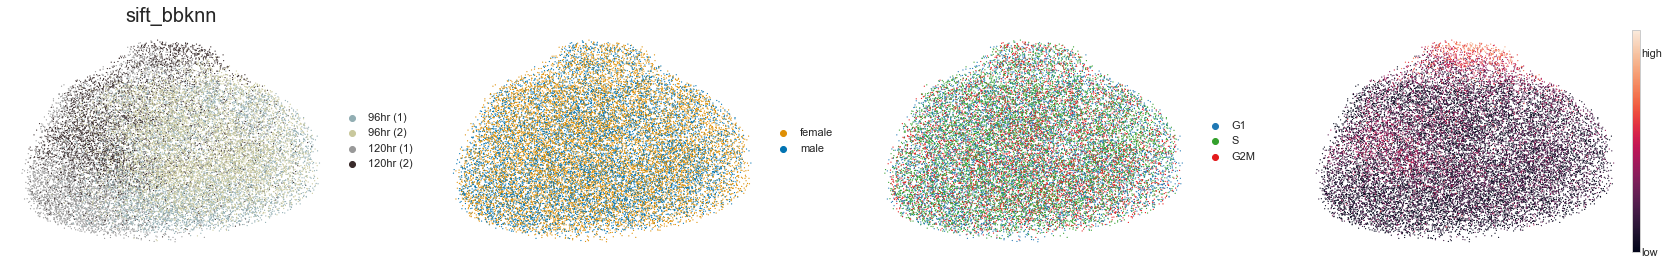

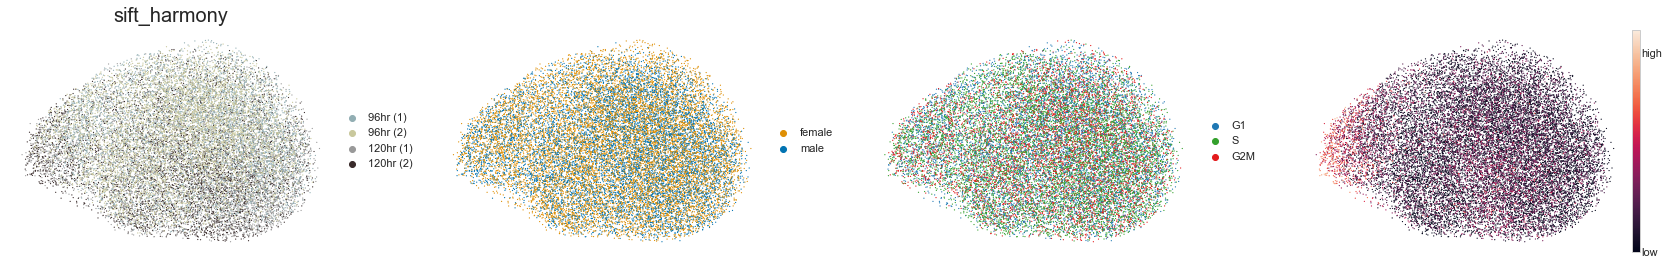

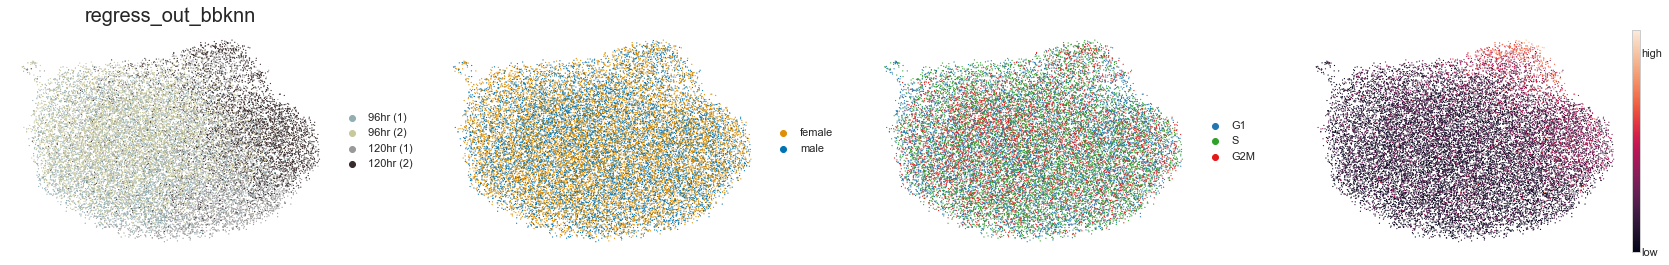

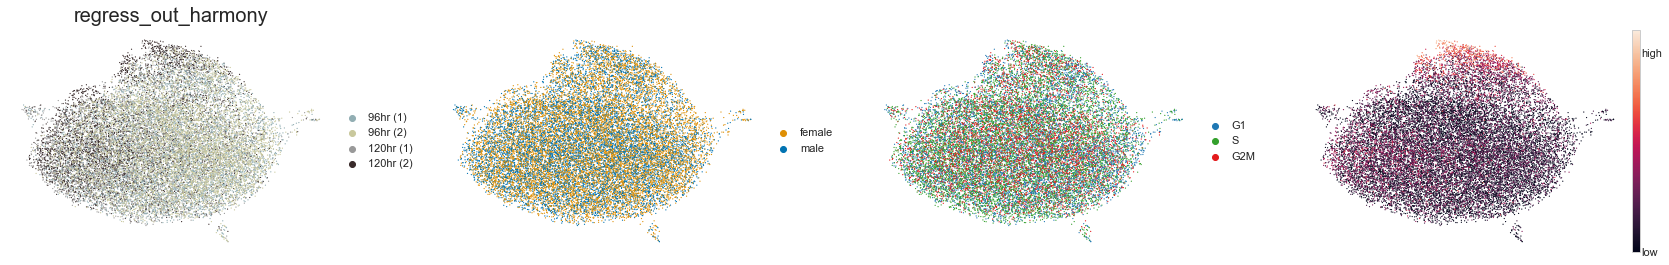

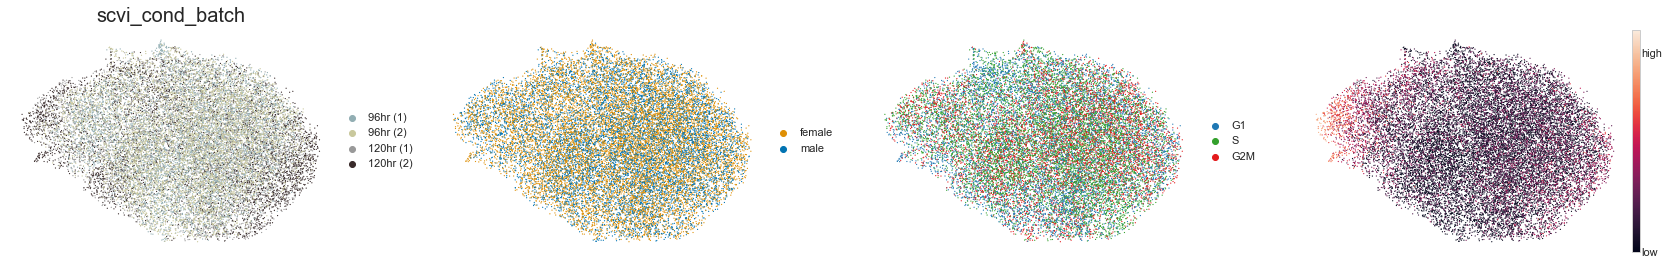

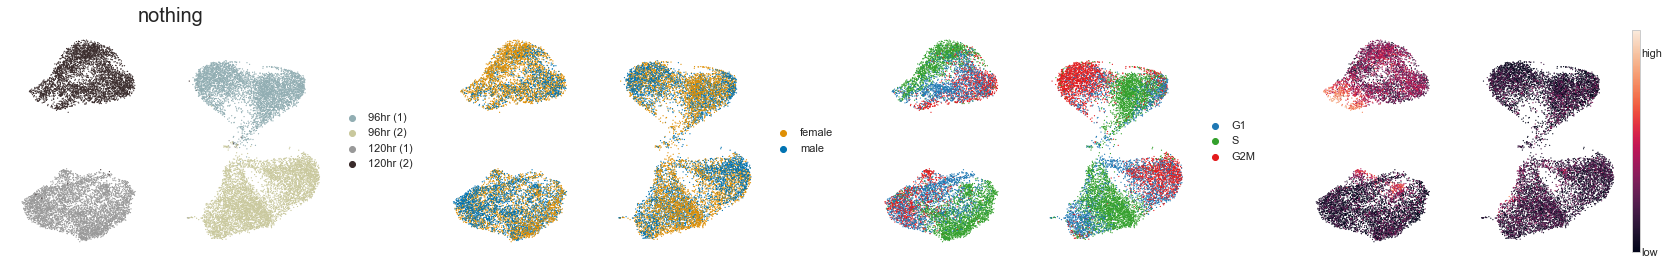

In [47]:
for key_, adata_ in adatas_.items():
    adata_ = set_adata_colors(adata_)
    fig = sc.pl.umap(
        adata_,
        color=["batch_str", "sex",  "phase", "Nrt"],
        frameon=False,
        wspace=0.2,
        return_fig=True,
    )
    
    for ax in fig.axes:
        ax.set_title("")
    fig.axes[0].set_title(key_, fontsize=20)
    g = fig.axes[-1].get_yaxis()
    g.set_ticks([0, 3.74])
    g.set_ticklabels(["low", "high"])
    # fig.savefig(FIG_DIR / f"dros_{key_}_umap.png", bbox_inches="tight", dpi=DPI)

## Quantitive analysis - `iLISI graph score`

In [48]:
metrics_eval = ["ilisi",]
batch_keys = ["phase","phase_sex"]

scores = {}
for metric_ in metrics_eval: 
    for key_ in batch_keys:
        scores[f"{metric_}_{key_}"]  = {}
        

In [49]:
methods_cmp = {
    'sift_bbknn': "SiFT (bbknn)",
    'sift_harmony': "SiFT (Harmony)",
    'regress_out_bbknn': "regress_out (bbknn)", 
    'regress_out_harmony': "regress_out (Harmony)", 
    'scvi_cond_batch': "scVI (batch & covariates)", 
    'nothing': "Original data", 
}

In [50]:
for method in methods_cmp:
    if "X_emb" not in adatas_[method].obsm:
        adatas_[method].obsm["X_emb"] = adatas_[method].obsm["X_pca"].copy()
        
    for batch_key in batch_keys:
        print(f"{method}-{batch_key}")
        
        # iLISI
        params = {
            "adata": adatas_[method],
            "batch_key": batch_key,
            "type_": "embed" #if "X_emb" in adatas_[method].obsm else "full"
        }
        
        scores[f"ilisi_{batch_key}"][f"{method}"] = scib.metrics.ilisi_graph(
            **params
        )
        score_ = scores[f"ilisi_{batch_key}"][f"{method}"]
        print(f"iLISI score: {score_}")
        


sift_bbknn-phase
iLISI score: 0.775732284737654
sift_bbknn-phase_sex
iLISI score: 0.6355782262425318
sift_harmony-phase
iLISI score: 0.775732284737654
sift_harmony-phase_sex
iLISI score: 0.6355782262425318
regress_out_bbknn-phase
iLISI score: 0.762469802879234
regress_out_bbknn-phase_sex
iLISI score: 0.6316462731797872
regress_out_harmony-phase
iLISI score: 0.7630225132407535
regress_out_harmony-phase_sex
iLISI score: 0.6311304038313755
scvi_cond_batch-phase
iLISI score: 0.7374957464428138
scvi_cond_batch-phase_sex
iLISI score: 0.6311208959557213
nothing-phase
iLISI score: 0.3269754702545752
nothing-phase_sex
iLISI score: 0.2986782274809821


In [51]:
df_scores = pd.DataFrame(scores).T
df_scores = df_scores.reset_index()
df_scores = df_scores.melt(id_vars=["index",]).rename(columns = {'index':'metric', 'value':'score'}, inplace = False)
df_scores["variable"] = df_scores["variable"].replace(methods_cmp)

### Save score

In [ ]:
df_scores.to_csv(DATA_DIR / "ilisi_scores_integration.csv")

### Plot res

In [52]:
methods_plot = {
    'sift_bbknn': "SiFT (bbknn)",
    'sift_harmony': "SiFT (Harmony)",
    'regress_out_bbknn': "regress_out (bbknn)", 
    'regress_out_harmony': "regress_out (Harmony)", 
    'scvi_cond_batch': "scVI (batch & covariates)", 
    'nothing': "Original data", 
}

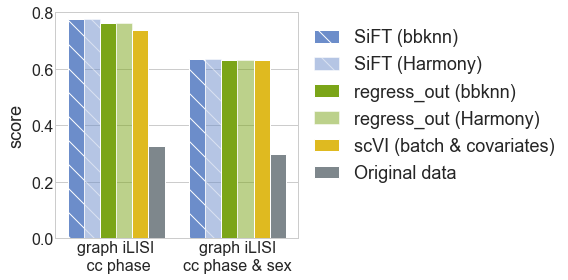

In [53]:
label_title = {"phase":"graph iLISI\n cc phase", "phase_sex": "graph iLISI\ncc phase & sex", "hvg": "HVG overlap"}

size = 4
fig, axs = plt.subplots(1,1, figsize=(size*2, size))


metrics_plot =  [f"ilisi_{label}" for label in ["phase", "phase_sex"]] 
metrics_plot.append("hvg")

df_scores_lim = df_scores[df_scores["metric"].isin(metrics_plot)].copy()
df_scores_lim.loc[:, "metric"] = df_scores_lim.loc[:, "metric"].replace({
        f"ilisi_{label}": label_title[label] for label in ["phase", "phase_sex"]
        
    }, inplace=False)

df_scores_lim.loc[:, "metric"] = df_scores_lim.loc[:, "metric"].replace({
        "hvg": "HVG overlap"
        }, inplace=False)

df_scores_lim = df_scores_lim[df_scores_lim["variable"].isin(methods_plot.values())]


# for var in df_scores_lim["variable"].unique():
#     mean_ = df_scores_lim[df_scores_lim["variable"] == var]["score"].mean()
#     df_scores_lim = df_scores_lim.append({"metric": "mean", "variable": var, "score": mean_}, ignore_index=True)

bar = sns.barplot(x="metric", y="score", data=df_scores_lim, hue="variable", 
                  ax=axs, palette=coupled_method_colors,)
# Define some hatches
hatches = ['\\', '\\', '\\','\\', 
              '', '', '', '', '', 
           '', '',  '', '', '',  '', '', ]
alphas = [1, 1, 0.5, 0.5, 1, 1, 0.5, 0.5, 1, 1, 1, 1,]
# Loop over the bars
for i, thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_alpha(alphas[i])
    
leg = axs.legend(ncol=1, 
                    loc="upper left", 
                    bbox_to_anchor=(1.0, 1.0),
                    frameon=False, fontsize=fontsize-2)
plt.title("")
plt.xticks(rotation=0,  fontsize=fontsize-4)
plt.ylim(0, 0.8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8] ,fontsize=fontsize-4)
plt.xlabel("", fontsize=fontsize-4)
plt.ylabel("score",  fontsize=fontsize-2)
plt.tight_layout()
# fig.savefig(FIG_DIR / f"score_iLISI_hvg_integrate.png", bbox_inches="tight", dpi=DPI)